## This is a FSI problem of 2D cylinder falling in a quiescent flow

Considering the fictitious fluid inside the cylinder due to immersed boundary method, also considering buoyancy.

To keep consistency between *Dyn3d* and *ViscousFlow*, the cylinder is setup in z-x coordinates, so gravity should also be set in z direction

In [1]:
using Pkg
Pkg.activate("..")
using FSI

In [2]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "passive_cylinder_neutrally_buoyant";

## Load initial condition from outside files

In [4]:
using ViscousFlow
@load "drag_cylinder_down.bson" w qJ v

In [5]:
qJ

6-element Array{Float64,1}:
  0.0                   
  4.12040284855966e-17  
  0.0                   
 -4.1504013179551503e-19
  0.0                   
 -0.5                   

In [6]:
v

6-element Array{Float64,1}:
  0.0                   
 -5.2757055390849955e-17
  0.0                   
  8.8186059785272e-18   
  0.0                   
 -1.0000000000000007    

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [7]:
ndim = 2
# numerical params
tf = 1.0
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0.0, -1.0]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
function circle(z₀::Vector{Float64}, r::Float64, n::Int)
    # z₀ for circle center location, r for radius and n for # of points on circle
    verts = zeros(n,2)
    for i = 1:n
        verts[i,:] = [r*cos(2π/(n)*(i-1)) + z₀[1], r*sin(2π/(n)*(i-1)) + z₀[2]]
    end
    return verts
end

nbody = 1
nverts = 157
verts = circle([0.,0.], 0.5, nverts)
config_body = ConfigBody(nbody, nverts, verts, 1.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dofₚ = Dof(6, "passive", 0., 0., Motions())
config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_z",
    [0.0,0.0,0.0,2.0,0.0,7.2+qJ[6]], zeros(Float64,6), 0, [dofₚ], [0.0],[v[6]])

 joint type = custom_prismatic_in_z
 joint position in parent body coord = [0.0, 0.0, 0.0, 2.0, 0.0, 6.7]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 6, under passive motion
 initial unconstrained dof position = [0.0]
 initial unconstrained dof velocity = [-1.0]


#### Build joint-body chain

In [8]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state to complete body-joint information

In [9]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [10]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [11]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

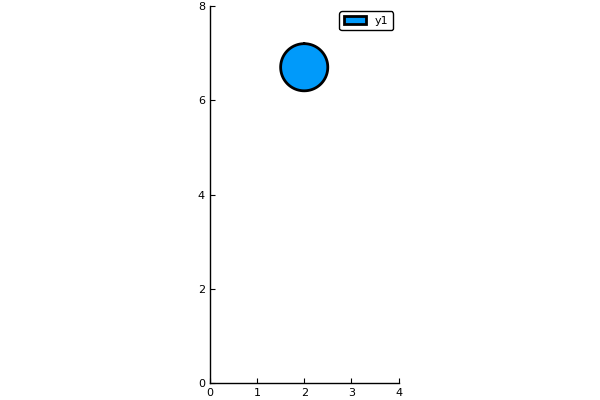

In [12]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
plot!(xlims=(0,4), ylims=(0,8),ratio=1)
# plot!(xlims=(0,2), ylims=(0,3),ratio=1)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [13]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [14]:
nx = 202; ny = 402;
Ly = 8.0;
# nx = 102; ny = 152;
# Ly = 3.0;
Δx = Ly/(ny-2);

Δt = min(0.5*Δx,0.5*Δx^2*Re)

w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:8.01)

#### Set up fluid initial conditions - already set at the beginning

In [15]:
# w₀ .= 0.0;
# w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [16]:
plane = [1,3];

#### Genrate body grid points and get linear velocity on them

In [17]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));

#### Get body points initial coordinates for fluids

In [18]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [19]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [20]:
tf = 1000Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2
Δt

0.01

## <span style="color:blue"> Create ifherk object </span>

In [21]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> FSI.Systems.plan_intfact(t,u,fsys), FSI.B₁ᵀ, FSI.B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), bd -> F(bd,config_body.ρ), w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=FSI.TimeMarching.RK31, bodydim=2, ρb=config_body.ρ)

 28.778205 seconds (59.03 M allocations: 6.150 GiB, 3.21% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [22]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [23]:
@time for ti in T

    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(round(Int,ti/Δt),200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

 28.408700 seconds (48.13 M allocations: 5.670 GiB, 3.00% gc time)
next time unit is 0.01
data saved at time 0.01
 24.809947 seconds (38.04 M allocations: 5.191 GiB, 2.46% gc time)
next time unit is 0.02
 24.570660 seconds (38.04 M allocations: 5.191 GiB, 2.08% gc time)
next time unit is 0.03
 26.832786 seconds (38.04 M allocations: 5.191 GiB, 2.46% gc time)
next time unit is 0.04
 27.092208 seconds (38.04 M allocations: 5.191 GiB, 2.09% gc time)
next time unit is 0.05
 27.012534 seconds (38.04 M allocations: 5.191 GiB, 2.09% gc time)
next time unit is 0.06
 27.382704 seconds (38.03 M allocations: 5.191 GiB, 2.49% gc time)
next time unit is 0.07
 27.869455 seconds (38.04 M allocations: 5.191 GiB, 2.06% gc time)
next time unit is 0.08
 28.097669 seconds (38.04 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 0.09
 28.284200 seconds (38.04 M allocations: 5.191 GiB, 2.05% gc time)
next time unit is 0.1
 31.720285 seconds (38.04 M allocations: 5.191 GiB, 1.91% gc time)
next time 

 24.202910 seconds (38.01 M allocations: 5.191 GiB, 2.05% gc time)
next time unit is 0.92
 24.067945 seconds (38.01 M allocations: 5.191 GiB, 2.06% gc time)
next time unit is 0.93
 24.236833 seconds (38.01 M allocations: 5.191 GiB, 2.41% gc time)
next time unit is 0.94
 24.134485 seconds (38.01 M allocations: 5.191 GiB, 2.06% gc time)
next time unit is 0.95
 24.229578 seconds (38.01 M allocations: 5.191 GiB, 2.41% gc time)
next time unit is 0.96
 24.085555 seconds (38.01 M allocations: 5.191 GiB, 2.05% gc time)
next time unit is 0.97
 24.085852 seconds (38.01 M allocations: 5.191 GiB, 2.07% gc time)
next time unit is 0.98
 24.218150 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 0.99
 24.094250 seconds (38.01 M allocations: 5.191 GiB, 2.06% gc time)
next time unit is 1.0
 24.180238 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 1.01
 24.075344 seconds (38.01 M allocations: 5.191 GiB, 2.06% gc time)
next time unit is 1.02
 24.163057 

 26.817048 seconds (38.01 M allocations: 5.191 GiB, 1.99% gc time)
next time unit is 1.84
 26.958674 seconds (38.01 M allocations: 5.191 GiB, 2.35% gc time)
next time unit is 1.85
 26.778938 seconds (38.01 M allocations: 5.191 GiB, 1.97% gc time)
next time unit is 1.86
 26.984994 seconds (38.01 M allocations: 5.191 GiB, 2.34% gc time)
next time unit is 1.87
 26.828270 seconds (38.01 M allocations: 5.191 GiB, 1.96% gc time)
next time unit is 1.88
 26.705623 seconds (38.01 M allocations: 5.191 GiB, 1.99% gc time)
next time unit is 1.89
 26.876605 seconds (38.01 M allocations: 5.191 GiB, 2.33% gc time)
next time unit is 1.9
 26.783579 seconds (38.01 M allocations: 5.191 GiB, 1.96% gc time)
next time unit is 1.91
 27.001155 seconds (38.01 M allocations: 5.191 GiB, 2.34% gc time)
next time unit is 1.92
 26.989268 seconds (38.01 M allocations: 5.191 GiB, 1.96% gc time)
next time unit is 1.93
 27.387501 seconds (38.01 M allocations: 5.191 GiB, 1.96% gc time)
next time unit is 1.94
 27.301590 

 27.553702 seconds (38.01 M allocations: 5.191 GiB, 1.99% gc time)
next time unit is 2.75
 27.312731 seconds (38.01 M allocations: 5.191 GiB, 2.38% gc time)
next time unit is 2.76
 27.419229 seconds (38.01 M allocations: 5.191 GiB, 1.99% gc time)
next time unit is 2.77
 27.650166 seconds (38.01 M allocations: 5.191 GiB, 2.37% gc time)
next time unit is 2.78
 27.323524 seconds (38.01 M allocations: 5.191 GiB, 1.99% gc time)
next time unit is 2.79
 27.535335 seconds (38.01 M allocations: 5.191 GiB, 2.00% gc time)
next time unit is 2.8
 27.744724 seconds (38.01 M allocations: 5.191 GiB, 2.36% gc time)
next time unit is 2.81
 27.488829 seconds (38.01 M allocations: 5.191 GiB, 1.97% gc time)
next time unit is 2.82
 27.691431 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 2.83
 27.384338 seconds (38.01 M allocations: 5.191 GiB, 1.99% gc time)
next time unit is 2.84
 27.340059 seconds (38.01 M allocations: 5.191 GiB, 1.99% gc time)
next time unit is 2.85
 27.418969 

 27.549418 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 3.67
 27.892686 seconds (38.01 M allocations: 5.191 GiB, 1.96% gc time)
next time unit is 3.68
 27.764182 seconds (38.01 M allocations: 5.191 GiB, 2.34% gc time)
next time unit is 3.69
 27.537865 seconds (38.01 M allocations: 5.191 GiB, 1.95% gc time)
next time unit is 3.7
 27.697712 seconds (38.01 M allocations: 5.191 GiB, 1.96% gc time)
next time unit is 3.71
 27.955723 seconds (38.01 M allocations: 5.191 GiB, 2.35% gc time)
next time unit is 3.72
 27.763961 seconds (38.01 M allocations: 5.191 GiB, 1.98% gc time)
next time unit is 3.73
 28.095645 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 3.74
 27.903709 seconds (38.01 M allocations: 5.191 GiB, 2.00% gc time)
next time unit is 3.75
 27.764831 seconds (38.01 M allocations: 5.191 GiB, 1.96% gc time)
next time unit is 3.76
 27.591216 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 3.77
 27.666066 

 29.424643 seconds (38.01 M allocations: 5.191 GiB, 2.34% gc time)
next time unit is 4.58
 29.568607 seconds (38.01 M allocations: 5.191 GiB, 1.99% gc time)
next time unit is 4.59
 31.140326 seconds (38.01 M allocations: 5.191 GiB, 1.93% gc time)
next time unit is 4.6
 30.599983 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 4.61
 29.387456 seconds (38.01 M allocations: 5.191 GiB, 1.97% gc time)
next time unit is 4.62
 30.098773 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 4.63
 31.545576 seconds (38.01 M allocations: 5.191 GiB, 1.97% gc time)
next time unit is 4.64
 31.890693 seconds (38.01 M allocations: 5.191 GiB, 1.96% gc time)
next time unit is 4.65
 31.091713 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 4.66
 30.260270 seconds (38.01 M allocations: 5.191 GiB, 1.98% gc time)
next time unit is 4.67
 30.521771 seconds (38.01 M allocations: 5.191 GiB, 2.36% gc time)
next time unit is 4.68
 30.682513 

 28.023370 seconds (38.01 M allocations: 5.191 GiB, 2.36% gc time)
next time unit is 5.5
 27.947217 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 5.51
 28.784124 seconds (38.01 M allocations: 5.191 GiB, 2.38% gc time)
next time unit is 5.52
 28.795863 seconds (38.01 M allocations: 5.191 GiB, 2.00% gc time)
next time unit is 5.53
 28.008045 seconds (38.01 M allocations: 5.191 GiB, 2.02% gc time)
next time unit is 5.54
 28.501796 seconds (38.01 M allocations: 5.191 GiB, 2.47% gc time)
next time unit is 5.55
 28.008131 seconds (38.01 M allocations: 5.191 GiB, 2.03% gc time)
next time unit is 5.56
 28.181837 seconds (38.01 M allocations: 5.191 GiB, 2.41% gc time)
next time unit is 5.57
 27.645915 seconds (38.01 M allocations: 5.191 GiB, 2.02% gc time)
next time unit is 5.58
 28.151382 seconds (38.01 M allocations: 5.191 GiB, 2.00% gc time)
next time unit is 5.59
 29.126117 seconds (38.01 M allocations: 5.191 GiB, 2.48% gc time)
next time unit is 5.6
 28.478391 s

 27.127788 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 6.41
 27.137480 seconds (38.01 M allocations: 5.191 GiB, 2.02% gc time)
next time unit is 6.42
 27.316733 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 6.43
 27.535948 seconds (38.01 M allocations: 5.191 GiB, 2.38% gc time)
next time unit is 6.44
 27.042402 seconds (38.01 M allocations: 5.191 GiB, 2.03% gc time)
next time unit is 6.45
 27.264882 seconds (38.01 M allocations: 5.191 GiB, 2.42% gc time)
next time unit is 6.46
 27.168411 seconds (38.01 M allocations: 5.191 GiB, 2.03% gc time)
next time unit is 6.47
 27.065794 seconds (38.01 M allocations: 5.191 GiB, 2.03% gc time)
next time unit is 6.48
 27.273426 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 6.49
 27.313343 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 6.5
 27.363639 seconds (38.01 M allocations: 5.191 GiB, 2.42% gc time)
next time unit is 6.51
 27.213548 

 27.552291 seconds (38.01 M allocations: 5.191 GiB, 2.05% gc time)
next time unit is 7.33
 27.443115 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 7.34
 27.433156 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 7.35
 27.101178 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 7.36
 27.527586 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 7.37
 27.423451 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 7.38
 27.549587 seconds (38.01 M allocations: 5.191 GiB, 2.05% gc time)
next time unit is 7.39
 27.309775 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 7.4
 27.515101 seconds (38.01 M allocations: 5.191 GiB, 2.03% gc time)
next time unit is 7.41
 27.400658 seconds (38.01 M allocations: 5.191 GiB, 2.40% gc time)
next time unit is 7.42
 27.696570 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 7.43
 27.493398 

 27.118713 seconds (38.01 M allocations: 5.191 GiB, 2.41% gc time)
next time unit is 8.24
 27.141239 seconds (38.01 M allocations: 5.191 GiB, 2.05% gc time)
next time unit is 8.25
 27.296332 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 8.26
 27.117494 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 8.27
 27.080133 seconds (38.01 M allocations: 5.191 GiB, 2.05% gc time)
next time unit is 8.28
 27.172459 seconds (38.01 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 8.29
 26.743296 seconds (38.01 M allocations: 5.191 GiB, 2.05% gc time)
next time unit is 8.3
 26.935784 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 8.31
 26.860164 seconds (38.01 M allocations: 5.191 GiB, 2.06% gc time)
next time unit is 8.32
 27.073985 seconds (38.01 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 8.33
 26.897152 seconds (38.01 M allocations: 5.191 GiB, 2.04% gc time)
next time unit is 8.34
 26.829390 

 26.851532 seconds (38.01 M allocations: 5.191 GiB, 2.07% gc time)
next time unit is 9.16
 27.172702 seconds (38.01 M allocations: 5.191 GiB, 2.59% gc time)
next time unit is 9.17
 27.272181 seconds (38.01 M allocations: 5.191 GiB, 2.07% gc time)
next time unit is 9.18
 27.849205 seconds (38.01 M allocations: 5.191 GiB, 2.08% gc time)
next time unit is 9.19
 27.569215 seconds (38.01 M allocations: 5.191 GiB, 2.48% gc time)
next time unit is 9.2
 27.612113 seconds (38.01 M allocations: 5.191 GiB, 2.07% gc time)
next time unit is 9.21
 28.094911 seconds (38.01 M allocations: 5.191 GiB, 2.50% gc time)
next time unit is 9.22
 27.985113 seconds (38.01 M allocations: 5.191 GiB, 2.07% gc time)
next time unit is 9.23
 28.157405 seconds (38.01 M allocations: 5.191 GiB, 2.07% gc time)
next time unit is 9.24
 27.461085 seconds (38.01 M allocations: 5.191 GiB, 2.49% gc time)
next time unit is 9.25
 27.546529 seconds (38.01 M allocations: 5.191 GiB, 2.07% gc time)
next time unit is 9.26
 27.616619 

In [37]:
@time for ti in 1001Δt:Δt:1500Δt

    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(round(Int,ti/Δt),200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

 24.632271 seconds (38.01 M allocations: 5.191 GiB, 3.78% gc time)
next time unit is 10.01
data saved at time 10.01
 24.747116 seconds (38.01 M allocations: 5.191 GiB, 3.66% gc time)
next time unit is 10.02
 25.288955 seconds (38.01 M allocations: 5.191 GiB, 2.55% gc time)
next time unit is 10.03
 24.781920 seconds (38.01 M allocations: 5.191 GiB, 2.91% gc time)
next time unit is 10.04
 24.271806 seconds (38.01 M allocations: 5.191 GiB, 2.36% gc time)
next time unit is 10.05
 24.748677 seconds (38.01 M allocations: 5.191 GiB, 2.33% gc time)
next time unit is 10.06
 25.418192 seconds (38.01 M allocations: 5.191 GiB, 2.71% gc time)
next time unit is 10.07
 24.019103 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 10.08
 24.410214 seconds (38.01 M allocations: 5.191 GiB, 2.81% gc time)
next time unit is 10.09
 24.274492 seconds (38.01 M allocations: 5.191 GiB, 2.37% gc time)
next time unit is 10.1
 24.207435 seconds (38.01 M allocations: 5.191 GiB, 2.37% gc time)

 23.694154 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 10.91
 24.542245 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 10.92
 23.887444 seconds (38.01 M allocations: 5.191 GiB, 2.79% gc time)
next time unit is 10.93
 23.992068 seconds (38.01 M allocations: 5.191 GiB, 2.40% gc time)
next time unit is 10.94
 25.038572 seconds (38.01 M allocations: 5.191 GiB, 2.76% gc time)
next time unit is 10.95
 24.818421 seconds (38.01 M allocations: 5.191 GiB, 2.40% gc time)
next time unit is 10.96
 25.254096 seconds (38.01 M allocations: 5.191 GiB, 2.40% gc time)
next time unit is 10.97
 25.212589 seconds (38.01 M allocations: 5.191 GiB, 2.79% gc time)
next time unit is 10.98
 25.109918 seconds (38.01 M allocations: 5.191 GiB, 2.39% gc time)
next time unit is 10.99
 25.021987 seconds (38.01 M allocations: 5.191 GiB, 2.81% gc time)
next time unit is 11.0
 24.875425 seconds (38.01 M allocations: 5.191 GiB, 2.37% gc time)
next time unit is 11.01


 23.811950 seconds (38.01 M allocations: 5.191 GiB, 2.83% gc time)
next time unit is 11.82
 23.693083 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 11.83
 23.752247 seconds (38.01 M allocations: 5.191 GiB, 2.85% gc time)
next time unit is 11.84
 23.696694 seconds (38.01 M allocations: 5.191 GiB, 2.42% gc time)
next time unit is 11.85
 23.748403 seconds (38.01 M allocations: 5.191 GiB, 2.79% gc time)
next time unit is 11.86
 23.638929 seconds (38.01 M allocations: 5.191 GiB, 2.40% gc time)
next time unit is 11.87
 23.666956 seconds (38.01 M allocations: 5.191 GiB, 2.42% gc time)
next time unit is 11.88
 23.741542 seconds (38.01 M allocations: 5.191 GiB, 2.82% gc time)
next time unit is 11.89
 23.649242 seconds (38.01 M allocations: 5.191 GiB, 2.41% gc time)
next time unit is 11.9
 23.775638 seconds (38.01 M allocations: 5.191 GiB, 2.82% gc time)
next time unit is 11.91
 23.677900 seconds (38.01 M allocations: 5.191 GiB, 2.40% gc time)
next time unit is 11.92


 23.691712 seconds (38.01 M allocations: 5.191 GiB, 2.41% gc time)
next time unit is 12.72
 23.897791 seconds (38.01 M allocations: 5.191 GiB, 2.82% gc time)
next time unit is 12.73
 23.679344 seconds (38.01 M allocations: 5.191 GiB, 2.42% gc time)
next time unit is 12.74
 23.812312 seconds (38.01 M allocations: 5.191 GiB, 2.82% gc time)
next time unit is 12.75
 23.696501 seconds (38.01 M allocations: 5.191 GiB, 2.42% gc time)
next time unit is 12.76
 23.661694 seconds (38.01 M allocations: 5.191 GiB, 2.42% gc time)
next time unit is 12.77
 23.790056 seconds (38.01 M allocations: 5.191 GiB, 2.82% gc time)
next time unit is 12.78
 23.719424 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 12.79
 23.833677 seconds (38.01 M allocations: 5.191 GiB, 2.84% gc time)
next time unit is 12.8
 23.709496 seconds (38.01 M allocations: 5.191 GiB, 2.42% gc time)
next time unit is 12.81
 23.712802 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 12.82


 23.848291 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 13.63
 23.925403 seconds (38.01 M allocations: 5.191 GiB, 2.84% gc time)
next time unit is 13.64
 23.874141 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 13.65
 23.907625 seconds (38.01 M allocations: 5.191 GiB, 2.84% gc time)
next time unit is 13.66
 23.800330 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 13.67
 23.885434 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 13.68
 23.942896 seconds (38.01 M allocations: 5.191 GiB, 2.81% gc time)
next time unit is 13.69
 23.808516 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 13.7
 23.946573 seconds (38.01 M allocations: 5.191 GiB, 2.83% gc time)
next time unit is 13.71
 23.817580 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 13.72
 23.862958 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 13.73


 23.941847 seconds (38.01 M allocations: 5.191 GiB, 2.86% gc time)
next time unit is 14.53
 23.859644 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 14.54
 23.914391 seconds (38.01 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 14.55
 23.998844 seconds (38.01 M allocations: 5.191 GiB, 2.84% gc time)
next time unit is 14.56
 23.877816 seconds (38.01 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 14.57
 24.034940 seconds (38.01 M allocations: 5.191 GiB, 2.86% gc time)
next time unit is 14.58
 23.885646 seconds (38.01 M allocations: 5.191 GiB, 2.44% gc time)
next time unit is 14.59
 23.871230 seconds (38.01 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 14.6
 23.992213 seconds (38.01 M allocations: 5.191 GiB, 2.83% gc time)
next time unit is 14.61
 23.874553 seconds (38.01 M allocations: 5.191 GiB, 2.47% gc time)
next time unit is 14.62
 23.897223 seconds (38.01 M allocations: 5.191 GiB, 2.85% gc time)
next time unit is 14.63


In [51]:
@time for ti in 1501Δt:Δt:1700Δt

    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")

end

 28.618644 seconds (38.01 M allocations: 5.191 GiB, 3.97% gc time)
next time unit is 15.01
 28.011820 seconds (38.01 M allocations: 5.191 GiB, 2.57% gc time)
next time unit is 15.02
 29.522133 seconds (38.01 M allocations: 5.191 GiB, 2.84% gc time)
next time unit is 15.03
 29.388142 seconds (38.01 M allocations: 5.191 GiB, 2.31% gc time)
next time unit is 15.04
 29.205826 seconds (38.01 M allocations: 5.191 GiB, 2.30% gc time)
next time unit is 15.05
 29.689407 seconds (38.01 M allocations: 5.191 GiB, 2.76% gc time)
next time unit is 15.06
 32.026214 seconds (38.01 M allocations: 5.191 GiB, 2.32% gc time)
next time unit is 15.07
 30.469491 seconds (38.01 M allocations: 5.191 GiB, 2.70% gc time)
next time unit is 15.08
 30.899181 seconds (38.01 M allocations: 5.191 GiB, 2.31% gc time)
next time unit is 15.09
 31.991575 seconds (38.01 M allocations: 5.191 GiB, 2.35% gc time)
next time unit is 15.1
 40.242642 seconds (38.01 M allocations: 5.191 GiB, 2.32% gc time)
next time unit is 15.11


 26.727894 seconds (38.01 M allocations: 5.191 GiB, 2.79% gc time)
next time unit is 15.92
 25.831402 seconds (38.01 M allocations: 5.191 GiB, 2.40% gc time)
next time unit is 15.93
 27.405462 seconds (38.01 M allocations: 5.191 GiB, 2.37% gc time)
next time unit is 15.94
 27.886602 seconds (38.01 M allocations: 5.191 GiB, 2.72% gc time)
next time unit is 15.95
 29.291231 seconds (38.01 M allocations: 5.191 GiB, 2.41% gc time)
next time unit is 15.96
 29.653198 seconds (38.01 M allocations: 5.191 GiB, 2.81% gc time)
next time unit is 15.97
 28.863165 seconds (38.01 M allocations: 5.191 GiB, 2.35% gc time)
next time unit is 15.98
 29.807884 seconds (38.01 M allocations: 5.191 GiB, 2.80% gc time)
next time unit is 15.99
 29.136584 seconds (38.01 M allocations: 5.191 GiB, 2.34% gc time)
next time unit is 16.0
 28.758681 seconds (38.01 M allocations: 5.191 GiB, 2.37% gc time)
next time unit is 16.01
 29.165804 seconds (38.01 M allocations: 5.191 GiB, 2.80% gc time)
next time unit is 16.02


 26.798742 seconds (38.01 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 16.83
 27.228472 seconds (38.01 M allocations: 5.191 GiB, 2.91% gc time)
next time unit is 16.84
 26.881507 seconds (38.01 M allocations: 5.191 GiB, 2.46% gc time)
next time unit is 16.85
 26.939029 seconds (38.01 M allocations: 5.191 GiB, 2.86% gc time)
next time unit is 16.86
 26.459555 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 16.87
 26.645708 seconds (38.01 M allocations: 5.191 GiB, 2.48% gc time)
next time unit is 16.88
 27.140248 seconds (38.01 M allocations: 5.191 GiB, 2.89% gc time)
next time unit is 16.89
 27.046895 seconds (38.01 M allocations: 5.191 GiB, 2.43% gc time)
next time unit is 16.9
 26.950286 seconds (38.01 M allocations: 5.191 GiB, 2.88% gc time)
next time unit is 16.91
 26.659971 seconds (38.01 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 16.92
 26.722298 seconds (38.01 M allocations: 5.191 GiB, 2.45% gc time)
next time unit is 16.93


## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [52]:
contour_levels = range(minimum(w.data),stop=maximum(w.data),length=40)
sample_freq = 5
fps = 25;

In [53]:
contour_levels

-0.03144527592041449:0.0016125782523311555:0.03144527592050057

#### Get body verts history

In [54]:
vshist = []
for i = 1:length(bdhist)
    push!(vshist, VertsHistory(bdhist[i].sys.nbody, bdhist[i].bs))
end
fb = [1:nverts;1];

#### Plot first and last time field

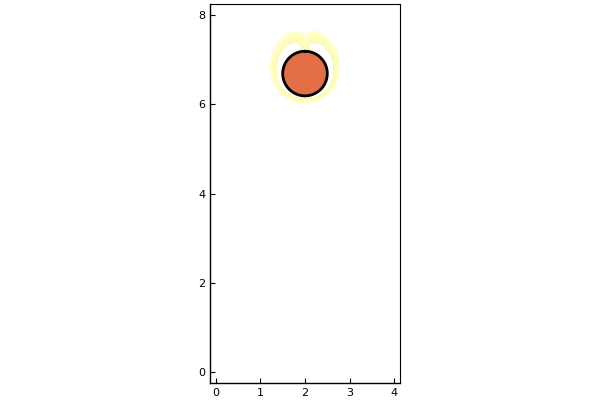

In [55]:
p = plot(xg,yg,whist[1],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

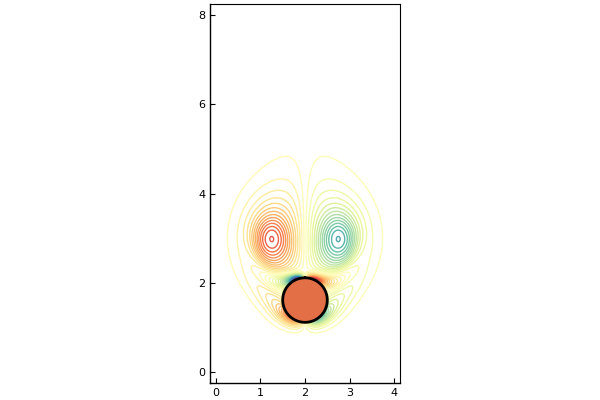

In [56]:
p = plot(xg,yg,whist[end],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

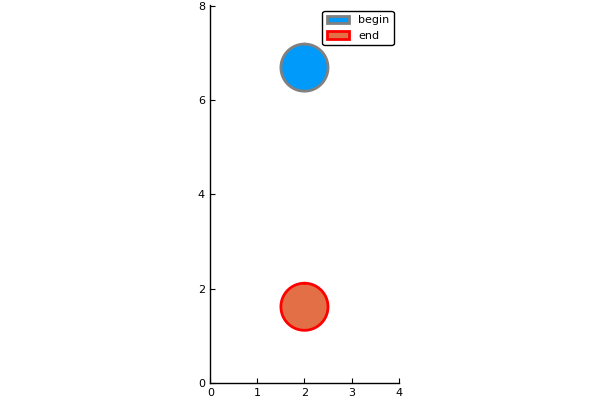

In [57]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="grey",label="begin",fill=true)
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="red",label="end",fill=true)
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### Make gif

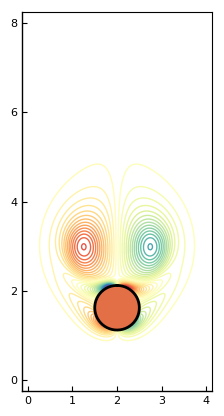

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/passive_cylinder_neutrally_buoyant.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/passive_cylinder_neutrally_buoyant.gif")

In [58]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels)
    for i = 1:sys.nbody
        plot!(vshist[j][i,fb,1], vshist[j][i,fb,plane[2]],linewidth=2,linecolor="black",fill=true)
    end
end

gif(anim, filename*".gif", fps = fps)

#### Get cylinder position and velocity in time

In [59]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[6])
    push!(phist,bdhist[i].bs[1].x_i[3]-bdhist[1].bs[1].x_i[3])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

#### Plot cylinder position, velocity, acceleration

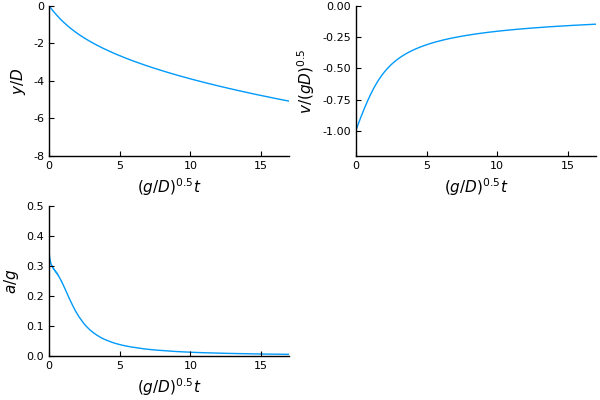

In [60]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,xlims=(0,t),ylims=(-8,0))
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,xlims=(0,t),ylims=(-1.2,0))
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false,xlims=(0,t),ylims=(0,0.5))

plot(pp,pv,pa)

In [61]:
ahist[1:3]

3-element Array{Any,1}:
 -99.64226845873604   
   0.34884522968375853
   0.3415751227218933 

#### Lift and drag coefficients

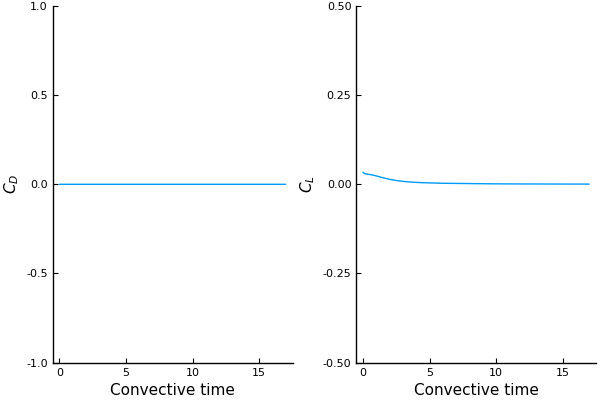

In [62]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-0.5,0.5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data .bson file

In [63]:
@save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [64]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);